<a href="https://colab.research.google.com/github/Anldrnz/DeepOnet/blob/main/DeepOnet_Integral_Operator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn import gaussian_process as gp
from scipy import interpolate
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import os
import time
import matplotlib.pyplot as plt
from functools import wraps

## Learning Modules

In [ ]:
def map_elementwise(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        container, idx = None, None
        for arg in args:
            if type(arg) in (list, tuple, dict):
                container, idx = type(arg), arg.keys() if type(arg) == dict else len(arg)
                break
        if container is None:
            for value in kwargs.values():
                if type(value) in (list, tuple, dict):
                    container, idx = type(value), value.keys() if type(value) == dict else len(value)
                    break
        if container is None:
            return func(*args, **kwargs)
        elif container in (list, tuple):
            get = lambda element, i: element[i] if type(element) is container else element
            return container(wrapper(*[get(arg, i) for arg in args],
                                     **{key: get(value, i) for key, value in kwargs.items()})
                             for i in range(idx))
        elif container is dict:
            get = lambda element, key: element[key] if type(element) is dict else element
            return {key: wrapper(*[get(arg, key) for arg in args],
                                 **{key_: get(value_, key) for key_, value_ in kwargs.items()})
                    for key in idx}

    return wrapper

In [ ]:
class Module(torch.nn.Module):
    '''Standard module format.
    '''

    def __init__(self):
        super(Module, self).__init__()
        self.activation = None
        self.initializer = None

        self.__device = None
        self.__dtype = None

    @property
    def device(self):
        return self.__device

    @property
    def dtype(self):
        return self.__dtype

    @device.setter
    def device(self, d):
        if d == 'cpu':
            self.cpu()
            for module in self.modules():
                if isinstance(module, Module):
                    module.__device = torch.device('cpu')
        elif d == 'gpu':
            self.cuda()
            for module in self.modules():
                if isinstance(module, Module):
                    module.__device = torch.device('cuda')
        else:
            raise ValueError

    @dtype.setter
    def dtype(self, d):
        if d == 'float':
            self.to(torch.float32)
            for module in self.modules():
                if isinstance(module, Module):
                    module.__dtype = torch.float32
        elif d == 'double':
            self.to(torch.float64)
            for module in self.modules():
                if isinstance(module, Module):
                    module.__dtype = torch.float64
        else:
            raise ValueError

    @property
    def act(self):
        if callable(self.activation):
            return self.activation
        elif self.activation == 'sigmoid':
            return torch.sigmoid
        elif self.activation == 'relu':
            return torch.relu
        elif self.activation == 'tanh':
            return torch.tanh
        elif self.activation == 'elu':
            return torch.elu
        else:
            raise NotImplementedError

    @property
    def weight_init_(self):
        if callable(self.initializer):
            return self.initializer
        elif self.initializer == 'He normal':
            return torch.nn.init.kaiming_normal_
        elif self.initializer == 'He uniform':
            return torch.nn.init.kaiming_uniform_
        elif self.initializer == 'Glorot normal':
            return torch.nn.init.xavier_normal_
        elif self.initializer == 'Glorot uniform':
            return torch.nn.init.xavier_uniform_
        elif self.initializer == 'orthogonal':
            return torch.nn.init.orthogonal_
        elif self.initializer == 'default':
            if self.activation == 'relu':
                return torch.nn.init.kaiming_normal_
            elif self.activation == 'tanh':
                return torch.nn.init.orthogonal_
            else:
                return lambda x: None
        else:
            raise NotImplementedError

    @map_elementwise
    def _to_tensor(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=self.dtype, device=self.device)
        return x


class Map(Module):
    '''Structure-oriented neural network used as a general map based on designing architecture.
    '''

    def __init__(self):
        super(Map, self).__init__()

    def predict(self, x, returnnp=False):
        x = self._to_tensor(x)
        return self(x).cpu().detach().numpy() if returnnp else self(x)


In [ ]:
class FNN(Map):

    def __init__(self, size, activation='relu', initializer='default'):
        super().__init__()
        self.size = size
        self.activation = activation
        self.initializer = initializer

        self.ms = self.__init_modules()
        self.__initialize()

    def forward(self, x):
        for i in range(1, len(self.size) - 1):
            x = self.act(self.ms['LinM{}'.format(i)](x))
        return self.ms['LinM{}'.format(len(self.size) - 1)](x) if self.size[-1] != 0 else x

    def __init_modules(self):
        modules = nn.ModuleDict()
        for i in range(1, len(self.size)):
            if self.size[i] != 0:
                bias = True if self.size[i] > 0 else False
                modules['LinM{}'.format(i)] = nn.Linear(abs(self.size[i - 1]), abs(self.size[i]), bias)
        return modules

    def __initialize(self):
        for i in range(1, len(self.size)):
            if self.size[i] != 0:
                self.weight_init_(self.ms['LinM{}'.format(i)].weight)
                if self.size[i] > 0:
                    nn.init.constant_(self.ms['LinM{}'.format(i)].bias, 0)

    

In [ ]:
class DeepONet(Map):
    '''Deep operator network.
    Input: ([batch size, branch_dim], [batch size, trunk_dim])
    Output: [batch size, 1]
    '''

    def __init__(self, branch_size, trunk_size, activation='relu', initializer='Glorot normal'):
        super().__init__()
        self.branch_size = branch_size
        self.trunk_size = trunk_size
        self.activation = activation
        self.initializer = initializer

        self.ms = self.__init_modules()
        self.ps = self.__init_params()

    def forward(self, x):
        x_branch, x_trunk = self.ms['Branch'](x[0]), self.ms['Trunk'](x[1])
        return torch.sum(x_branch * x_trunk, dim=-1, keepdim=True) + self.ps['bias']

    def __init_modules(self):
        modules = nn.ModuleDict()
        modules['Branch'] = FNN(self.branch_size, self.activation, self.initializer)
        modules['Trunk'] = FNN(self.trunk_size, self.activation, self.initializer)
        return modules

    def __init_params(self):
        params = nn.ParameterDict()
        params['bias'] = nn.Parameter(torch.zeros([1]))
        return params



## Data preparation

In [ ]:
class Data:
    '''Standard data format.
    '''

    def __init__(self, X_train=None, y_train=None, X_test=None, y_test=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.__device = None
        self.__dtype = None

    def get_batch(self, batch_size):
        @map_elementwise
        def batch_mask(X, num):
            return np.random.choice(X.size(0), num, replace=False)

        @map_elementwise
        def batch(X, mask):
            return X[mask]

        mask = batch_mask(self.y_train, batch_size)
        return batch(self.X_train, mask), batch(self.y_train, mask)

    @property
    def device(self):
        return self.__device

    @property
    def dtype(self):
        return self.__dtype

    @device.setter
    def device(self, d):
        if d == 'cpu':
            self.__to_cpu()
            self.__device = torch.device('cpu')
        elif d == 'gpu':
            self.__to_gpu()
            self.__device = torch.device('cuda')
        else:
            raise ValueError

    @dtype.setter
    def dtype(self, d):
        if d == 'float':
            self.__to_float()
            self.__dtype = torch.float32
        elif d == 'double':
            self.__to_double()
            self.__dtype = torch.float64
        else:
            raise ValueError


    def __to_cpu(self):
        @map_elementwise
        def trans(d):
            if isinstance(d, np.ndarray):
                return torch.DoubleTensor(d)
            elif isinstance(d, torch.Tensor):
                return d.cpu()

        for d in ['X_train', 'y_train', 'X_test', 'y_test']:
            setattr(self, d, trans(getattr(self, d)))

    def __to_float(self):
        if self.device is None:
            raise RuntimeError('device is not set')

        @map_elementwise
        def trans(d):
            if isinstance(d, torch.Tensor):
                return d.float()

        for d in ['X_train', 'y_train', 'X_test', 'y_test']:
            setattr(self, d, trans(getattr(self, d)))

    def __to_double(self):
        if self.device is None:
            raise RuntimeError('device is not set')

        @map_elementwise
        def trans(d):
            if isinstance(d, torch.Tensor):
                return d.double()

        for d in ['X_train', 'y_train', 'X_test', 'y_test']:
            setattr(self, d, trans(getattr(self, d)))


class IntegralData(Data):
    '''Data for learning the antiderivative operator.
    '''

    def __init__(self, s0, sensors, p, T_begin, T_end, length_scale, train_num, test_num):
        super().__init__()
        self.s0 = s0
        self.sensors = sensors
        self.p = p
        self.T_begin = T_begin
        self.T_end = T_end
        self.T = self.T_end - self.T_begin
        self.length_scale = length_scale
        self.train_num = train_num
        self.test_num = test_num
        self.__init_data()

    def __init_data(self):
        features = 2000
        train = self.__gaussian_process(self.train_num, features, self.T_begin, self.T_end)
        test = self.__gaussian_process(self.test_num, features, self.T_begin, self.T_end)
        self.X_train, self.y_train = self.__generate(train, self.T_begin, self.T_end)
        self.X_test, self.y_test = self.__generate(test, self.T_begin, self.T_end)

    def __generate(self, gps, T_begin, T_end):
        def generate(gp):
            u = interpolate.interp1d(np.linspace(T_begin, T_end, num=gp.shape[-1]), gp, kind='cubic', copy=False,
                                     assume_sorted=True)
            x = np.sort(np.random.rand(self.p))*(T_end-T_begin) + T_begin
            y = solve_ivp(lambda t, y: u(t), [T_begin, T_end], self.s0, 'RK45', x).y[0]
            u_sensors = u(np.linspace(T_begin, T_end, num=self.sensors))
            return np.hstack([np.tile(u_sensors, (self.p, 1)), x[:, None], y[:, None]])

        res = np.vstack(list(map(generate, gps)))
        return (res[..., :-2], res[..., -2:-1]), res[..., -1:]

    def __gaussian_process(self, num, features, T_begin, T_end):
        x = np.linspace(T_begin, T_end, num=features)[:, None]
        A = gp.kernels.RBF(length_scale=self.length_scale)(x)
        L = np.linalg.cholesky(A + 1e-13 * np.eye(features))
        return (L @ np.random.randn(features, num)).transpose()


## Training objects

In [ ]:
class Train:

    def __init__(self, data, net, criterion, optimizer, lr, iterations, batch_size,
                 print_every, save, callback, dtype, device):
        self.data = data
        self.net = net
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr = lr
        self.iterations = iterations
        self.batch_size = batch_size
        self.print_every = print_every
        self.save = save
        self.callback = callback
        self.dtype = dtype
        self.device = device
        self.loss_history = None
        self.encounter_nan = False
        self.best_model = None
        self.__optimizer = None
        self.__criterion = None

    def run(self):
        self.__init_brain()
        print('Training...', flush=True)
        loss_history = []
        for i in range(self.iterations + 1):
            if self.batch_size is not None:
                X_train, y_train = self.data.get_batch(self.batch_size)
                loss = self.__criterion(self.net(X_train), y_train)
            else:
                loss = self.__criterion(self.net(self.data.X_train), self.data.y_train)
            if i % self.print_every == 0 or i == self.iterations:
                loss_test = self.__criterion(self.net(self.data.X_test), self.data.y_test)
                loss_history.append([i, loss.item(), loss_test.item()])
                print('{:<9}Train loss: {:<25}Test loss: {:<25}'.format(i, loss.item(), loss_test.item()), flush=True)
                if torch.any(torch.isnan(loss)):
                    self.encounter_nan = True
                    print('Encountering nan, stop training', flush=True)
                    return None
                if self.save:
                    if not os.path.exists('model'): os.mkdir('model')
                    torch.save(self.net, 'model/model{}.pkl'.format(i))
                if self.callback is not None:
                    to_stop = self.callback(self.data, self.net)
                    if to_stop: break
            if i < self.iterations:
                self.__optimizer.zero_grad()
                loss.backward()
                self.__optimizer.step()
        self.loss_history = np.array(loss_history)
        print('Done!', flush=True)
        return self.loss_history

    def restore(self):
        if self.loss_history is not None and self.save == True:
            best_loss_index = np.argmin(self.loss_history[:, 1])
            iteration = int(self.loss_history[best_loss_index, 0])
            loss_train = self.loss_history[best_loss_index, 1]
            loss_test = self.loss_history[best_loss_index, 2]
            print('Best model at iteration {}:'.format(iteration), flush=True)
            print('Train loss:', loss_train, 'Test loss:', loss_test, flush=True)
            self.best_model = torch.load('model/model{}.pkl'.format(iteration))
        else:
            raise RuntimeError('restore before running or without saved models')
        return self.best_model

    def output(self, data=True, best_model=True, loss_history=True, path=None, **kwargs):
        if path is None:
            path = './outputs/' + time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
        if not os.path.isdir(path): os.makedirs(path)
        if data:
            def save_data(fname, data):
                if isinstance(data, dict):
                    np.savez_compressed(path + '/' + fname, **data)
                elif isinstance(data, list) or isinstance(data, tuple):
                    np.savez_compressed(path + '/' + fname, *data)
                else:
                    np.save(path + '/' + fname, data)

        if best_model:
            torch.save(self.best_model, path + '/model_best.pkl')
        if loss_history:
            np.savetxt(path + '/loss.txt', self.loss_history)
        for key, arg in kwargs.items():
            np.savetxt(path + '/' + key + '.txt', arg)

    def __init_brain(self):
        self.loss_history = None
        self.encounter_nan = False
        self.best_model = None
        self.data.device = self.device
        self.data.dtype = self.dtype
        self.net.device = self.device
        self.net.dtype = self.dtype
        self.__init_optimizer()
        self.__init_criterion()

    def __init_optimizer(self):
        if self.optimizer == 'adam':
            self.__optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        else:
            raise NotImplementedError

    def __init_criterion(self):
        if self.criterion == 'MSE':
            self.__criterion = torch.nn.MSELoss()
        elif self.criterion == 'CrossEntropy':
            self.__criterion = cross_entropy_loss
        else:
            raise NotImplementedError


## Train and fit

In [ ]:
device = 'cpu' # 'cpu' or 'gpu'
s0 = [0] # Initial condition
sensors = 500
p = 1
T_begin = 0
T_end = 5
length_scale = 0.2
train_num = 5000
test_num = 2000
# deeponet
branch_size = [sensors, 40, 40]
trunk_size = [1, 40, 40, 0]  # = [1, 40, 40] followed by activation
activation = 'relu'
# training
lr = 0.001
iterations = 10000
print_every = 1000

data = IntegralData(s0, sensors, p, T_begin, T_end, length_scale, train_num, test_num)
net = DeepONet(branch_size, trunk_size, activation)
args = {
'data': data,
'net': net,
'criterion': 'MSE',
'optimizer': 'adam',
'lr': lr,
'iterations': iterations,
'batch_size': None,
'print_every': print_every,
'save': True,
'callback': None,
'dtype': 'float',
'device': device
}



In [ ]:
train = Train(**args)
train.run()
train.restore()
train.output()

Training...
0        Train loss: 6.15546178817749         Test loss: 6.215357780456543        
1000     Train loss: 0.017102621495723724     Test loss: 0.03305851295590401      
2000     Train loss: 0.011082603596150875     Test loss: 0.027162963524460793     
3000     Train loss: 0.008049762807786465     Test loss: 0.023918716236948967     
4000     Train loss: 0.006551920901983976     Test loss: 0.02323303557932377      
5000     Train loss: 0.0057870615273714066    Test loss: 0.0230085588991642       
6000     Train loss: 0.005379072390496731     Test loss: 0.02287225052714348      
7000     Train loss: 0.004687319975346327     Test loss: 0.022081254050135612     
8000     Train loss: 0.004425571300089359     Test loss: 0.021416209638118744     
9000     Train loss: 0.003892623819410801     Test loss: 0.019810901954770088     
10000    Train loss: 0.0036400984972715378    Test loss: 0.01819591410458088      
Done!
Best model at iteration 10000:
Train loss: 0.0036400984972715378 Test

## Plotting

In [ ]:
def plot(data, net, T_begin, T_end):
    x = np.linspace(T_begin, T_end, num=data.sensors)
    y = np.linspace(T_begin, T_end, num=100)

    out = np.cos(2 * np.pi * x)
    antide_true = np.sin(2 * np.pi * y) / (2 * np.pi)
    antide_pred = net.predict([np.tile(out, (len(y), 1)), y[:, None]], returnnp=True).squeeze()
    
    #out = x/2 - np.cos(2 * np.pi * x)
    #antide_true = y * y / 4 - np.sin(2 * np.pi * y) / (2 * np.pi)
    #antide_pred = net.predict([np.tile(out, (len(y), 1)), y[:, None]], returnnp=True).squeeze()

    #out =  x*x
    #antide_true = y*y*y*0.333
    #antide_pred = net.predict([np.tile(out, (len(y), 1)), y[:, None]], returnnp=True).squeeze()

    plt.figure(figsize=(20, 8))
    plt.plot(x, out, color='black', label=r'Input: $x-\cos(2\pi x)$', zorder=0)
    plt.plot(y, antide_true, color='b', label=r'Output: $x^2/2 - \sin(2\pi x)/(2\pi)$', zorder=1)
    plt.plot(y, antide_pred, color='r', label=r'Prediction', zorder=2)
    plt.legend()
    #plt.savefig('deeponet.pdf')


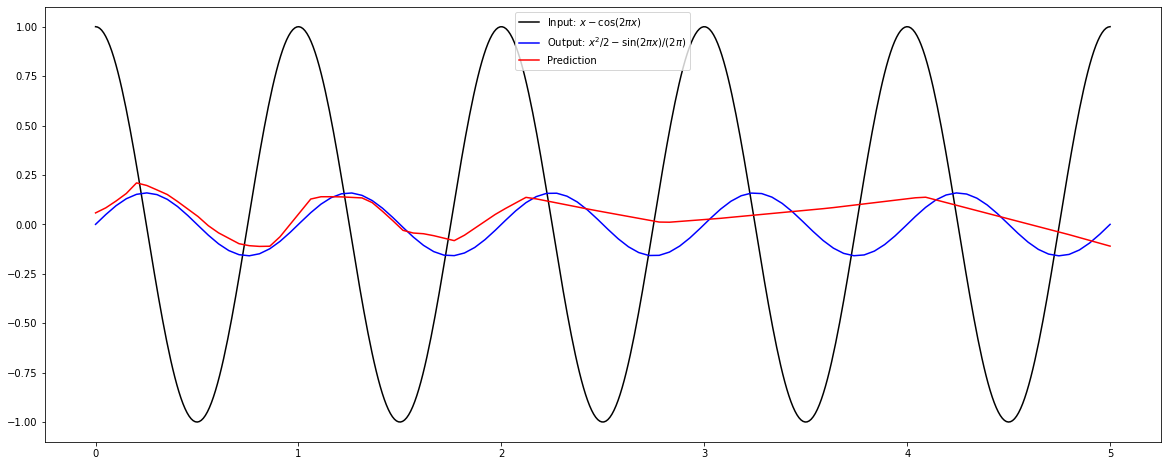

In [ ]:
plot(data, torch.load('model/model{}.pkl'.format(10000)), T_begin, T_end)

## Trials for functions

In [ ]:
import matplotlib.pyplot as plt

def my_gaussian_process(num, features, T, scale):
    x = np.linspace(0, T, num=features)[:, None]
    K = gp.kernels.RBF(length_scale=scale)(x)
    L = np.linalg.cholesky(K + 1e-13 * np.eye(features))
    return (L @ np.random.randn(features, num)).transpose()


def my_generate(gps, T):
    def generate(gp):
        u = interpolate.interp1d(np.linspace(0, T, num=gp.shape[-1]), gp, kind='cubic', copy=False,
                                  assume_sorted=True)
        x = np.sort(np.random.rand(p))
        y = solve_ivp(lambda t, y: u(t), [0, T], s0, 'RK45', x).y[0]
        u_sensors = u(np.linspace(0, T, num=sensors))
        return np.hstack([np.tile(u_sensors, (p, 1)), x[:, None], y[:, None]])

    res = np.vstack(list(map(generate, gps)))
    return (res[..., :-2], res[..., -2:-1]), res[..., -1:]

In [ ]:
T = 2
features = 2000
s0 = [0]
sensors = 100
p = 1
length_scale = 0.2
train_num = 1000
test_num = 1000

train = my_gaussian_process(train_num, features, T, length_scale)
test = my_gaussian_process(test_num, features, T, length_scale)
X_train, y_train = my_generate(train, T)
X_test, y_test = my_generate(test, T)

In [ ]:
print(f"train: {len(train)}\n{train.shape}\n")
print(f"X_train: {len(X_train[0][0])}\n{len(X_train[0])}\n{len(X_train[1])}")
print(f"y_train: {len(y_train[0])}\n{len(y_train)}")

#print(f"X_train 0: {X_train[0]}")
#print(f"X_train 1: {X_train[1]}")


train: 1000
(1000, 2000)

X_train: 100
1000
1000
y_train: 1
1000


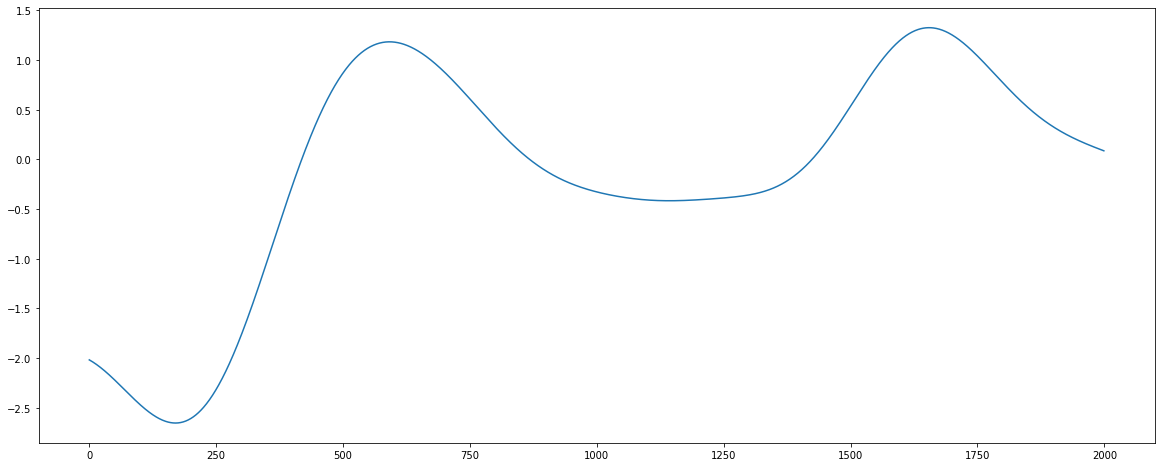

In [ ]:
# plot gaussian process raw training data
plt.figure(figsize=(20, 8))
for i in range(int(len(train)*0.001)):
  plt.plot(train[i])


<Figure size 432x288 with 0 Axes>

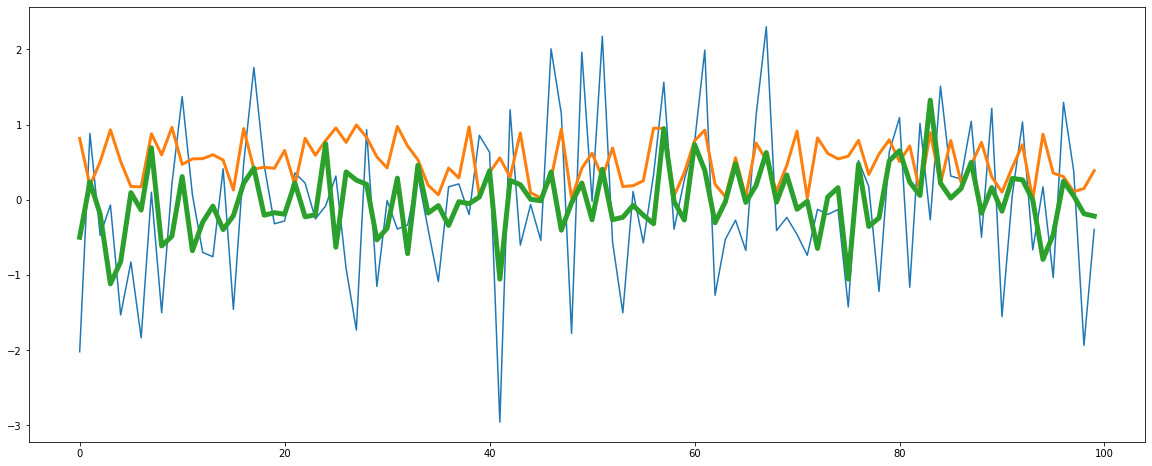

In [ ]:
# plot X training data
plt.clf()
plt.figure(figsize=(20, 8))
plt.plot(X_train[0][:100,0:1])
plt.plot(X_train[1][:100], linewidth=3)
plt.plot(y_train[0:100], linewidth=5)

# __sense function crops the data tenfold, length drops from 1000 to 100 without changing the behaviour of data.